In [2]:
import pandas as pd
import numpy as np
from datetime import timedelta
from typing import Set
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier

import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_score
from scipy.stats import rankdata

Create a set function that includes the construction process of all feature values. Of course, such a collection does not come from a single natural process; in fact, these ideas gradually formed through repeated training. To present them more conveniently, these feature sets are presented here in a classified manner.

In [3]:
# This function is the core of our ETL pipeline for the User Churn Prediction model.
# INPUT: Raw user log data (clickstream) from the server.
# OUTPUT: A clean Feature Matrix (X) where one row = one user.

# KEY CONCEPTS:
# 1. "Snapshot Window": We don't just look at totals. We explicitly compare lifetime behavior vs the last 7 days to catch recent changes in habit.
# 2. "Psychological Proxy": We're trying to model user feelings .
# Boredom? (Low entropy/diversity), Frustration? (High error rates + frequent clicks), Panic / Urgent Churn? (Sudden drop in velocity)

# It prepares the data directly for the XGBoost/Random Forest classifier.

def etl_pandas_data(df_raw: pd.DataFrame, include_label: bool = True) -> pd.DataFrame:
    df = df_raw.copy()

    # Basic Cleaning
    # Drop ghost users and fix types
    df = df[df['userId'] != ""]
    df['dt'] = pd.to_datetime(df['ts'], unit='ms')
    df.sort_values(by=['userId', 'ts'], inplace=True)

    # Label Gen
    # identifying who actually churned based on the cancellation page
    churn_user_ids: Set[str] = set()
    if include_label:
        churn_user_ids = set(df[df['page'] == "Cancellation Confirmation"]['userId'].unique())

    # Helper Cols (One-hot & Session logic)
    event_cols = ['NextSong', 'Thumbs Up', 'Thumbs Down', 'Error', 'Roll Advert', 
                  'Add Friend', 'Add to Playlist', 'Home', 'Settings', 'Help',
                  'Submit Upgrade', 'Submit Downgrade']
    
    # OHE for page events
    for p in event_cols:
        col_name = f'is_{p.replace(" ", "")}'
        df[col_name] = (df['page'] == p).astype(int)

    # Session/Duration Calcs
    df['next_ts'] = df.groupby('userId')['ts'].shift(-1)
    # Duration in seconds
    df['duration'] = (df['next_ts'] - df['ts']) / 1000 
    # Flagging "skips" or very short plays (< 30s)
    df['is_ShortPlay'] = ((df['page'] == 'NextSong') & (df['duration'] < 30)).astype(int)

    # Time context
    df['hour'] = df['dt'].dt.hour
    df['is_night'] = df['hour'].apply(lambda x: 1 if (x >= 22 or x <= 5) else 0)
    df['is_weekend'] = df['dt'].dt.dayofweek.apply(lambda x: 1 if x >= 5 else 0)
    
    # Gap Calculation (Critical for 'Gap Analysis' features later)
    df['prev_ts_gap'] = df.groupby('userId')['ts'].shift(1)
    df['gap_hours'] = (df['ts'] - df['prev_ts_gap']) / (1000 * 3600)

    # Intermediate Calculations (Pre-Aggregation)
    
    # 1. Lifecycle (Anchors for the time window)
    user_lifecycle = df.groupby('userId')['ts'].agg(['min', 'max']).reset_index()
    user_lifecycle.columns = ['userId', 'user_min_ts', 'user_max_ts']
    df = df.merge(user_lifecycle, on='userId', how='left')
    
    # 2. Snapshot Window Flag (Last 7 days of user activity)
    # Note: 7 * 24 * 3600 * 1000 ms
    df['in_last_week'] = (df['ts'] >= (df['user_max_ts'] - 7 * 24 * 3600 * 1000))

    # 3. Recent Behavior (V9 - Catching negative signals in the window)
    df['NextSong_LastWeek'] = df['is_NextSong'] * df['in_last_week']
    df['Error_LastWeek'] = df['is_Error'] * df['in_last_week']
    df['RollAdvert_LastWeek'] = df['is_RollAdvert'] * df['in_last_week']
    df['ThumbsDown_LastWeek'] = df['is_ThumbsDown'] * df['in_last_week']
    df['ShortPlay_LastWeek']  = df['is_ShortPlay'] * df['in_last_week']
    
    # Deep Session Aggregation
    # Group by SessionId first to get stats per session
    session_stats = df.groupby(['userId', 'sessionId']).agg(
        sess_duration=('ts', lambda x: (x.max() - x.min()) / 1000), 
        sess_songs=('is_NextSong', 'sum'),                          
        sess_errors=('is_Error', 'sum')                             
    ).reset_index()
    
    # Then aggregate to User level (Mean/Std of session behaviors)
    user_session_features = session_stats.groupby('userId').agg(
        avg_songs_per_session=('sess_songs', 'mean'),  
        std_songs_per_session=('sess_songs', 'std'),   
        avg_session_duration=('sess_duration', 'mean') 
    ).reset_index()

    # Independent Calculation Modules
    # Active Days (Only within the snapshot window)
    active_days_df = df[df['in_last_week']].groupby('userId')['dt'].apply(lambda x: x.dt.date.nunique()).reset_index(name='active_days_last_week')
    
    # Entropy Calculation (V9 - Exploring Diversity/Stability)
    # Artist Entropy (Are they listening to the same stuff?)
    artist_counts = df[df['page'] == 'NextSong'][['userId', 'artist']].groupby(['userId', 'artist']).size().reset_index(name='play_count')
    feat_entropy = artist_counts.groupby('userId')['play_count'].apply(lambda x: entropy(x, base=2)).to_frame('Artist_Entropy')
    
    # Song Entropy
    track_counts = df[df['page'] == 'NextSong'][['userId', 'song']].groupby(['userId', 'song']).size().reset_index(name='play_count')
    feat_song_entropy = track_counts.groupby('userId')['play_count'].apply(lambda x: entropy(x, base=2)).to_frame('Song_Entropy')

    # Action Entropy (Diversity of UI interactions)
    action_counts_df = df.groupby(['userId', 'page']).size().reset_index(name='action_count')
    feat_action_entropy = action_counts_df.groupby('userId')['action_count'].apply(lambda x: entropy(x, base=2)).to_frame('Action_Entropy')

    # Hour Entropy (Regularity of usage times)
    hour_counts_df = df.groupby(['userId', 'hour']).size().reset_index(name='hour_count')
    feat_hour_entropy = hour_counts_df.groupby('userId')['hour_count'].apply(lambda x: entropy(x, base=2)).to_frame('Hour_Entropy')
    
    # New Artist Exploration Ratio
    one_off_artists = artist_counts[artist_counts['play_count'] == 1].groupby('userId').size()
    total_artists = artist_counts.groupby('userId').size()

    # Main Aggregation
    # Flattening everything to UserID level
    feature_df = df.groupby('userId').agg(
        gender=('gender', 'first'),
        level_final=('level', 'last'), 
        user_min_ts=('user_min_ts', 'min'),
        user_max_ts=('user_max_ts', 'max'),
        Avg_Gap_Hours=('gap_hours', 'mean'),
        Std_Gap_Hours=('gap_hours', 'std'),
        Night_Ratio=('is_night', 'mean'),    
        
        # Total metrics (Denominators)
        total_songs=('is_NextSong', 'sum'),
        total_errors=('is_Error', 'sum'),
        total_thumbs_up=('is_ThumbsUp', 'sum'),
        total_thumbs_down=('is_ThumbsDown', 'sum'),
        total_short_plays=('is_ShortPlay', 'sum'),
        total_adverts=('is_RollAdvert', 'sum'),
        total_friends=('is_AddFriend', 'sum'),
        total_playlist=('is_AddtoPlaylist', 'sum'),
        total_settings=('is_Settings', 'sum'),
        total_help=('is_Help', 'sum'),
        total_home=('is_Home', 'sum'),
        
        total_actions=('page', 'count'),      
        total_sessions=('sessionId', 'nunique'), 
        unique_songs=('song', 'nunique'),     
        
        # Snapshot metrics (Numerators - Last Week)
        songs_last_week=('NextSong_LastWeek', 'sum'),
        errors_last_week=('Error_LastWeek', 'sum'),
        adverts_last_week=('RollAdvert_LastWeek', 'sum'),
        thumbs_down_last_week=('ThumbsDown_LastWeek', 'sum'),
        short_plays_last_week=('ShortPlay_LastWeek', 'sum'),
        
        total_weekend_actions=('is_weekend', 'sum'),
        
        Downgraded=('is_SubmitDowngrade', 'max'), 
        Upgraded=('is_SubmitUpgrade', 'max')      
    ).reset_index()

    # Merge all independent feature blocks
    feature_df = feature_df.merge(user_session_features, on='userId', how='left')
    feature_df = feature_df.merge(active_days_df, on='userId', how='left')
    feature_df = feature_df.merge(feat_entropy.reset_index(), on='userId', how='left')
    feature_df = feature_df.merge(feat_song_entropy.reset_index(), on='userId', how='left')
    feature_df = feature_df.merge(feat_action_entropy.reset_index(), on='userId', how='left')
    feature_df = feature_df.merge(feat_hour_entropy.reset_index(), on='userId', how='left')
    
    feature_df['one_off_count'] = feature_df['userId'].map(one_off_artists).fillna(0)
    feature_df['total_unique_artists'] = feature_df['userId'].map(total_artists).fillna(0)
    feature_df.fillna(0, inplace=True) # Fill NaNs from session agg (e.g., users with 0 sessions? edge case)

    # Final Feature Construction
    
    # 1. Basic Time Feats (Fixing lifecycle bias)
    feature_df['retain_time_days'] = (feature_df['user_max_ts'] - feature_df['user_min_ts']) / (1000 * 3600 * 24)
    feature_df['retain_time_days'] = feature_df['retain_time_days'].replace(0, 0.01) # Avoid div by zero
    
    # Recency (Distance from global max)
    global_max_ts = df['ts'].max() 
    feature_df['Recency_Hours'] = (global_max_ts - feature_df['user_max_ts']) / (1000 * 3600)
    feature_df['activelast1week'] = feature_df['active_days_last_week'] / 7.0

    # 2. Core Ratios & Trends (V9 - Velocity & Change)
    feature_df['Velocity_Songs'] = feature_df['total_songs'] / feature_df['retain_time_days'] # Daily avg
    feature_df['daily_avg_songs'] = feature_df['Velocity_Songs'] # legacy alias
    
    feature_df['last_week_avg_songs'] = feature_df['songs_last_week'] / 7.0
    # Activity_Trend: Recent Velocity / Lifetime Velocity
    feature_df['Activity_Trend'] = feature_df['last_week_avg_songs'] / (feature_df['daily_avg_songs'] + 0.001)
    feature_df['Trend_Songs'] = feature_df['Activity_Trend'] # legacy alias
    
    is_paid = (feature_df['level_final'] == 'paid').astype(int)
    feature_df['Paid_Inactivity_Risk'] = is_paid * (1.0 - feature_df['Activity_Trend'])

    # Diversity Exploration
    feature_df['NewArtistRatio'] = feature_df['one_off_count'] / feature_df['total_unique_artists'].replace(0, 1)
    feature_df['Song_Repeat_Ratio'] = 1.0 - (feature_df['unique_songs'] / feature_df['total_songs'].replace(0, 1))
    
    # 3. Basic Session/Action Ratios (V9 - Normalized features)
    feature_df['SongPerSession'] = feature_df['total_songs'] / feature_df['total_sessions'].replace(0, 1)
    feature_df['AdvertsPerSession'] = feature_df['total_adverts'] / feature_df['total_sessions'].replace(0, 1)
    feature_df['AddFriendPerSession'] = feature_df['total_friends'] / feature_df['total_sessions'].replace(0, 1)
    feature_df['ErrorRate'] = feature_df['total_errors'] / feature_df['total_actions'].replace(0, 1)
    feature_df['ThumbsUpPerSong'] = feature_df['total_thumbs_up'] / feature_df['total_songs'].replace(0, 1)
    feature_df['ThumbsDownPerSong'] = feature_df['total_thumbs_down'] / feature_df['total_songs'].replace(0, 1)
    feature_df['SkipRate'] = feature_df['total_short_plays'] / feature_df['total_songs'].replace(0, 1)
    feature_df['HomeRate'] = feature_df['total_home'] / feature_df['total_actions'].replace(0, 1)
    feature_df['SettingsHelpRate'] = (feature_df['total_settings'] + feature_df['total_help']) / feature_df['total_actions'].replace(0, 1)

    # 4. Deep Psych Features
    feature_df['Songs_Per_Advert'] = feature_df['total_songs'] / (feature_df['total_adverts'] + 1)
    
    positive_interactions = feature_df['total_thumbs_up'] + feature_df['total_playlist']
    negative_interactions = feature_df['total_thumbs_down'] + feature_df['total_errors'] + feature_df['total_short_plays']
    feature_df['Sentiment_Ratio'] = positive_interactions / (negative_interactions + 1)

    # Frustration Trends
    daily_avg_short = feature_df['total_short_plays'] / feature_df['retain_time_days']
    last_week_avg_short = feature_df['short_plays_last_week'] / 7.0
    feature_df['ShortPlay_Trend'] = last_week_avg_short / (daily_avg_short + 0.001)

    daily_avg_ads = feature_df['total_adverts'] / feature_df['retain_time_days']
    last_week_avg_ads = feature_df['adverts_last_week'] / 7.0
    feature_df['Advert_Trend'] = last_week_avg_ads / (daily_avg_ads + 0.001)

    feature_df['Weekend_Ratio'] = feature_df['total_weekend_actions'] / feature_df['total_actions'].replace(0, 1)
    
    # 5. Supplementary Interaction Feats
    feature_df['Avg_Time_Per_Song'] = feature_df['avg_session_duration'] / (feature_df['avg_songs_per_session'] + 1)
    # Silent Attrition: Long retention * Low recent trend
    feature_df['Silent_Attrition_Score'] = feature_df['retain_time_days'] * (1 - feature_df['Activity_Trend'])

    # 6. Encoding
    feature_df['level_state'] = is_paid

    # Cleanup / Drop intermediate cols
    cols_to_drop = [
        'gender', 'level_final', 'user_min_ts', 'user_max_ts',
        # Dropping denominators (raw sums)
        'total_songs', 'total_errors', 'total_thumbs_up', 'total_thumbs_down',
        'total_short_plays', 'total_adverts', 'total_friends', 'total_playlist',
        'total_settings', 'total_help', 'total_home', 
        'total_actions', 'total_sessions', 'unique_songs',
        # Dropping numerators (snapshot sums)
        'songs_last_week', 'errors_last_week', 'active_days_last_week',
        'one_off_count', 'total_unique_artists',
        'adverts_last_week', 'thumbs_down_last_week', 'short_plays_last_week',
        'total_weekend_actions',
        # Intermediate trends
        'last_week_avg_songs'
    ]
    
    final_df = feature_df.drop(columns=cols_to_drop, errors='ignore')

    # Interaction 1: Frustration Index (High Error Rate + Low Activity Trend)
    final_df['Frustration_Index'] = final_df['ErrorRate'] / (final_df['Activity_Trend'] + 0.01)
    
    # Interaction 2: Boredom/Burnout (Low exploration + Low recent activity)
    final_df['Boredom_Score'] = (1 - final_df['NewArtistRatio']) * (1 - final_df['activelast1week'])
    
    # Interaction 3: Panic/High Risk (High Hist. Volume + Sudden Drop)
    final_df['Panic_Score'] = final_df['daily_avg_songs'] * (1.0 - final_df['Activity_Trend'])
    
    # Interaction 4: Deep Usage Ratio (Avg songs per sess * Recency factor)
    final_df['Deep_Usage'] = final_df['avg_songs_per_session'] / (final_df['Recency_Hours'] + 1)
    
    # Interaction 5: Bad Post-Upgrade Experience (Paid * Errors)
    final_df['Upgraded_Error_Interaction'] = final_df['Upgraded'] * final_df['ErrorRate']
    
    # Interaction 6: "Zombie Member" (Paid / No Recent Activity)
    final_df['Upgraded_Inactivity'] = final_df['Upgraded'] / (final_df['activelast1week'] + 0.01)
    
    # Interaction 7: "Ad Fatigue" (Free User * High Ads)
    final_df['Free_Advert_Impact'] = (1 - final_df['level_state']) * final_df['AdvertsPerSession']
    
    # Interaction 8: "Bored Veteran" (Long time user * Zero exploration)
    final_df['Bored_Veteran'] = final_df['retain_time_days'] * (1 - final_df['NewArtistRatio'])

    if include_label:
        final_df['label'] = final_df['userId'].apply(lambda x: 1 if x in churn_user_ids else 0)

    # Clean up column ordering
    cols = [c for c in final_df.columns if c not in ['userId', 'label']]
    final_cols = ['userId'] + cols
    if 'label' in final_df.columns:
        final_cols.append('label')
        
    return final_df[final_cols]

Read the raw data

In [4]:
# 1. Load raw data (.parquet format helps load faster)
df_train_raw = pd.read_parquet('train.parquet')
df_test_raw = pd.read_parquet('test.parquet')

### Dataset Preparation

This wrapper is the core component that prepares the dataset for the model. Its primary purpose is to solve the **"Time Travel" problem**, ensuring that we do not accidentally ingest future data during the training process.


#### Key Mechanisms

* **Time Cutoff (Simulation of Future)**
    The function first sets the time cutoff based on the **`observation_window`** (default 14 days). In training mode, it looks back in time to reserve the last 14 days of data for generating true churn labels, thereby strictly simulating future prediction scenarios.

* **Refined Sample Weighting (Zombie Handling)**
    The function introduces a refined sample weighting adjustment mechanism to improve signal quality:
    * It uses **`silence_threshold_days`** (default 30 days) to identify long-term inactive 'zombie users'.
    * It reduces the weight of such samples in training through **`zombie_weight`** (default 0.5).
    * **Impact**: This effectively prevents the noise from silent users from interfering with the model's learning of proactive churn characteristics.

In [5]:
# This function creates a strict "Snapshot" at a specific date.
# 1. For Training: We cut off the last 14 days to use as the "Answer Key" (Label).
# 2. For Prediction: We use the full timeline up to right now.

def create_snapshot_dataset(df_raw, observation_window=14, silence_threshold_days=30, zombie_weight=0.5, mode='train'):

    df = df_raw.copy()

    # 1. Timeline Setup
    df['dt'] = pd.to_datetime(df['ts'], unit='ms')
    max_date = df['dt'].max()
    
    # Difference 1: The Cutoff Point
    if mode == 'train':
        # Train mode: We need to hide the last 14 days to verify labels later
        split_date = max_date - pd.Timedelta(days=observation_window)
        print(f"[Train Mode] Cutoff: {split_date} (Reserved {observation_window} days for validation)")
    else:
        # Predict mode: We use data right up to the last second
        split_date = max_date
        print(f"[Predict Mode] Cutoff: {split_date} (Using full data)")

    # 2. Splitting History
    # df_future will be empty in Predict mode, which is expected
    df_history = df[df['dt'] <= split_date].copy()
    df_future = df[df['dt'] > split_date].copy()

    # 3. Handling Explicit Churn (Hard Removal)
    # If someone already Cancelled in the history buffer, we don't need to predict them.
    # They are already gone.
    dead_users_explicit = set(df_history[df_history['page'] == "Cancellation Confirmation"]['userId'].unique())
    print(f"Removing explicit churners: {len(dead_users_explicit)} users")
    df_history = df_history[~df_history['userId'].isin(dead_users_explicit)]

    # 4. Handling Zombie Users
    # Identifying users who have been silent for too long
    last_active = df_history.groupby('userId')['dt'].max()
    silence_limit = split_date - pd.Timedelta(days=silence_threshold_days)
    zombie_users = set(last_active[last_active < silence_limit].index)
    print(f"Identifying Zombies: {len(zombie_users)} users")

    # 5. Feature Engineering (Calling the ETL function)
    print("Generating features...")
    # We pass include_label=False because we handle labels manually below based on the split
    X_snapshot = etl_pandas_data(df_history, include_label=False)

    # 6. Injecting Valid Recency (Completing the puzzle)
    # Ensuring userId types match
    df_history['userId'] = df_history['userId'].astype(str)
    X_snapshot['userId'] = X_snapshot['userId'].astype(str)
    
    user_last_ts_map = df_history.groupby('userId')['dt'].max()
    X_snapshot['user_last_dt'] = X_snapshot['userId'].map(user_last_ts_map)
    
    # Calculating hours relative to the Snapshot date (not the global max)
    X_snapshot['Recency_To_Snapshot'] = (split_date - X_snapshot['user_last_dt']).dt.total_seconds() / 3600.0
    X_snapshot.drop(columns=['user_last_dt'], inplace=True)

    # 7. Label Generation
    if mode == 'train':
        # Train: Look at the 'future' buffer to see who actually churned
        churn_users_future = set(df_future[df_future['page'] == "Cancellation Confirmation"]['userId'].unique())
        X_snapshot['label'] = X_snapshot['userId'].apply(lambda x: 1 if x in churn_users_future else 0)
    else:
        # Predict: We don't have the future, so fill 0 or NaN
        print("[Predict Mode] Cannot generate real labels, filling 0.")
        X_snapshot['label'] = 0 
    
    # 8. Sample Weights
    def assign_weight(user_id):
        if user_id in zombie_users:
            return zombie_weight 
        else:
            return 1.0 
    X_snapshot['sample_weight'] = X_snapshot['userId'].apply(assign_weight)

    return X_snapshot

Call the snapshot function and then call the feature engineering function in the window to perform the data engineering.

In [6]:
# Create snapshot. 
# zombie_weight=0.01 forces the model to ignore inactive users and focus on behavior.
train_df_snap = create_snapshot_dataset(
    df_train_raw, 
    observation_window=14,
    silence_threshold_days=30,
    zombie_weight=0.01,
    mode='train'
)

# Make sure we still have enough positive cases
new_churn_rate = train_df_snap['label'].mean()
print(f"New Churn Rate (Next 14 days): {new_churn_rate:.2%}")

[Train Mode] Cutoff: 2018-11-06 00:00:00 (Reserved 14 days for validation)
Removing explicit churners: 3253 users
Identifying Zombies: 312 users
Generating features...
New Churn Rate (Next 14 days): 6.49%


In [7]:
test_df_snap = create_snapshot_dataset(df_test_raw, mode='predict')

[Predict Mode] Cutoff: 2018-11-20 00:00:00 (Using full data)
Removing explicit churners: 0 users
Identifying Zombies: 53 users
Generating features...
[Predict Mode] Cannot generate real labels, filling 0.


In [8]:
train_df_snap.columns.tolist()

['userId',
 'Avg_Gap_Hours',
 'Std_Gap_Hours',
 'Night_Ratio',
 'Downgraded',
 'Upgraded',
 'avg_songs_per_session',
 'std_songs_per_session',
 'avg_session_duration',
 'Artist_Entropy',
 'Song_Entropy',
 'Action_Entropy',
 'Hour_Entropy',
 'retain_time_days',
 'Recency_Hours',
 'activelast1week',
 'Velocity_Songs',
 'daily_avg_songs',
 'Activity_Trend',
 'Trend_Songs',
 'Paid_Inactivity_Risk',
 'NewArtistRatio',
 'Song_Repeat_Ratio',
 'SongPerSession',
 'AdvertsPerSession',
 'AddFriendPerSession',
 'ErrorRate',
 'ThumbsUpPerSong',
 'ThumbsDownPerSong',
 'SkipRate',
 'HomeRate',
 'SettingsHelpRate',
 'Songs_Per_Advert',
 'Sentiment_Ratio',
 'ShortPlay_Trend',
 'Advert_Trend',
 'Weekend_Ratio',
 'Avg_Time_Per_Song',
 'Silent_Attrition_Score',
 'level_state',
 'Frustration_Index',
 'Boredom_Score',
 'Panic_Score',
 'Deep_Usage',
 'Upgraded_Error_Interaction',
 'Upgraded_Inactivity',
 'Free_Advert_Impact',
 'Bored_Veteran',
 'Recency_To_Snapshot',
 'label',
 'sample_weight']

To avoid noise interference, even though we ultimately used tree models, which are not particularly sensitive to linear collinearity, we check for correlations before formal training.

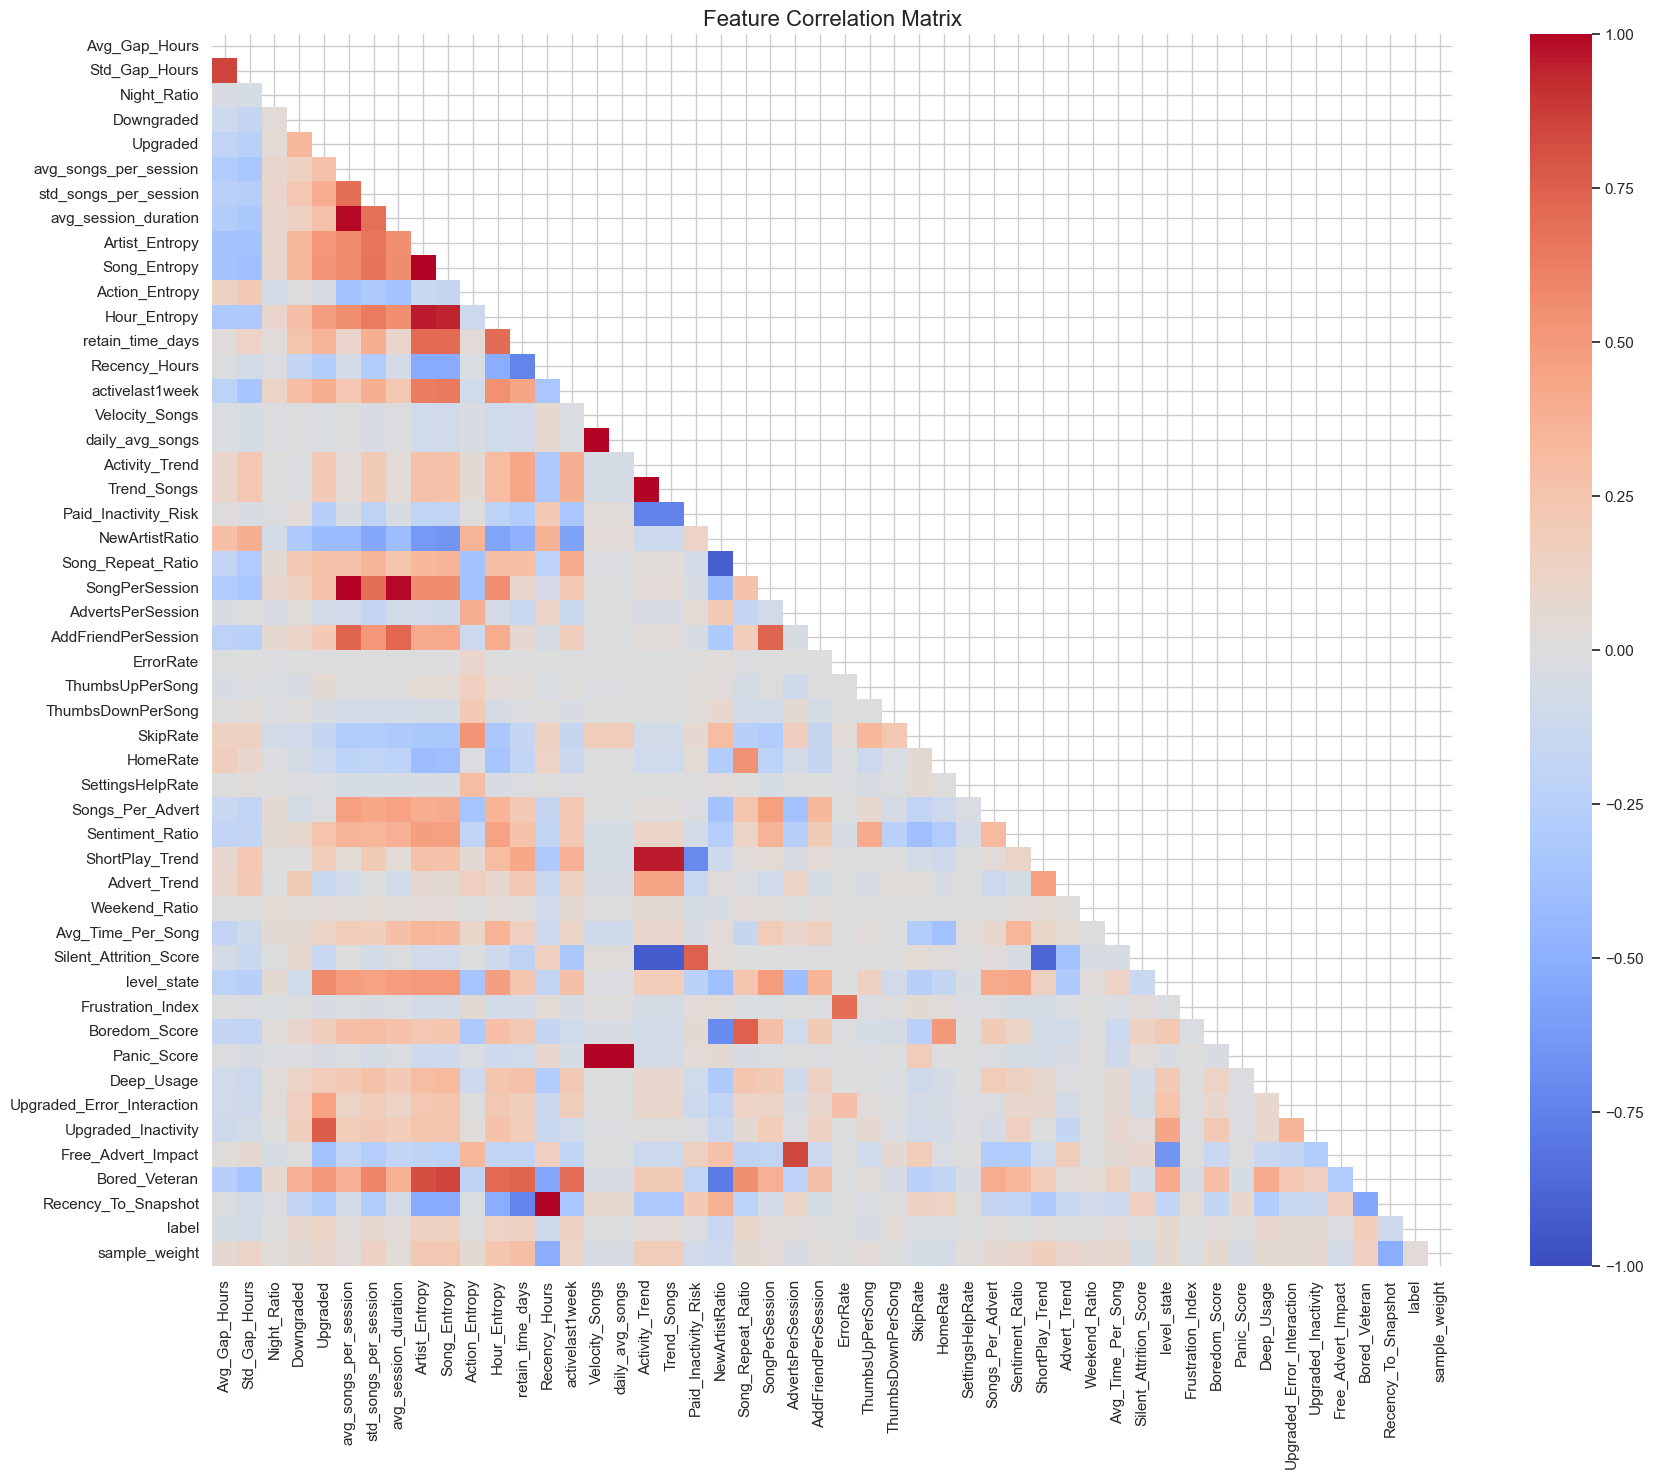


 High Multicollinearity Check (Threshold > 0.8) ---
Found 21 pairs of highly correlated features:
------------------------------------------------------------
Feature A                      | Feature B                      | Corr
------------------------------------------------------------
Velocity_Songs                 | daily_avg_songs                | 1.0000
avg_songs_per_session          | SongPerSession                 | 1.0000
Recency_Hours                  | Recency_To_Snapshot            | 1.0000
Activity_Trend                 | Trend_Songs                    | 1.0000
Velocity_Songs                 | Panic_Score                    | 0.9996
daily_avg_songs                | Panic_Score                    | 0.9996
Artist_Entropy                 | Song_Entropy                   | 0.9982
avg_session_duration           | SongPerSession                 | 0.9906
avg_songs_per_session          | avg_session_duration           | 0.9906
Trend_Songs                    | ShortPlay_Trend   

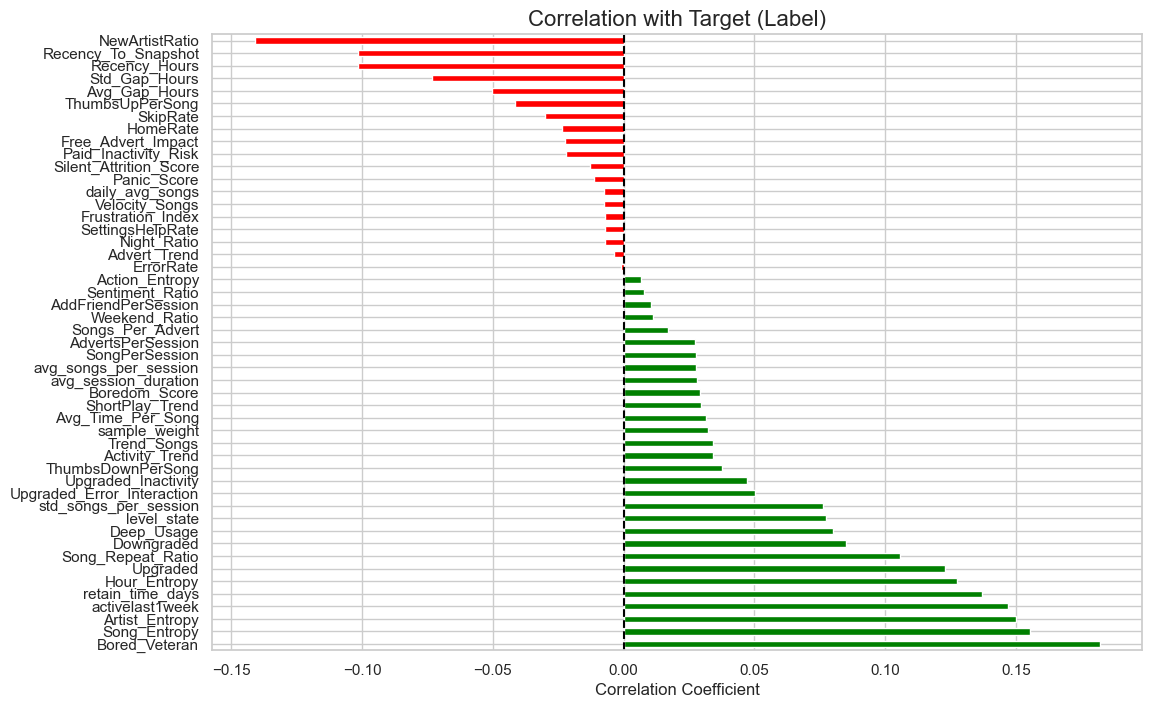


 Top 5 Positive Correlations (Promotes Churn):
Bored_Veteran       0.182205
Song_Entropy        0.155242
Artist_Entropy      0.150001
activelast1week     0.146927
retain_time_days    0.137028
Name: label, dtype: float64

 Top 5 Negative Correlations (Prevents Churn):
Avg_Gap_Hours         -0.050391
Std_Gap_Hours         -0.073455
Recency_Hours         -0.101698
Recency_To_Snapshot   -0.101698
NewArtistRatio        -0.141084
Name: label, dtype: float64


In [9]:
# Set plot style to something readable
sns.set(style="whitegrid")

# Before throwing this into XGBoost, we need to check two things:
# 1. Multicollinearity: Are we feeding the model duplicate info? (e.g., "days_active" vs "hours_active") If correlation > 0.9, the model might get confused or unstable.
# 2. Signal Strength: Do any of our features actually correlate with the label? If the top correlation is like 0.01, we are in trouble.

def plot_correlation_analysis(df, threshold=0.9):
    # Filter for numeric columns only (drop IDs)
    numeric_df = df.select_dtypes(include=['int64', 'float64', 'int32', 'float32'])

    # Compute the big matrix
    corr_matrix = numeric_df.corr()

    plt.figure(figsize=(20, 16))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask upper triangle
    sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Feature Correlation Matrix', fontsize=16)
    plt.show()

    print(f"\n High Multicollinearity Check (Threshold > {threshold}) ---")

    # Select upper triangle only (k=1) to avoid self-correlation (A vs A) and duplicates (A vs B, B vs A)
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Stack to Series and filter by threshold
    stacked_corr = upper_tri.stack()
    high_corr_pairs = stacked_corr[stacked_corr.abs() > threshold]

    if len(high_corr_pairs) == 0:
        print(f"No feature pairs found with correlation > {threshold}")
    else:
        # Sort by strength (absolute value)
        high_corr_pairs = high_corr_pairs.sort_values(key=abs, ascending=False)
        print(f"Found {len(high_corr_pairs)} pairs of highly correlated features:")
        print("-" * 60)
        print(f"{'Feature A':<30} | {'Feature B':<30} | {'Corr'}")
        print("-" * 60)
        for (f1, f2), val in high_corr_pairs.items():
            print(f"{f1:<30} | {f2:<30} | {val:.4f}")
        print("-" * 60)

    
    # Target Correlation (The "Truth" Check)

    if 'label' in corr_matrix.columns:
        # We don't care about label vs label (it's 1.0)
        target_corr = corr_matrix['label'].drop('label').sort_values(ascending=False)

        plt.figure(figsize=(12, 8))
        # Green = Risk Factors (Positive Corr), Red = Retention Factors (Negative Corr)
        colors = ['green' if x > 0 else 'red' for x in target_corr.values]
        target_corr.plot(kind='barh', color=colors)
        plt.title('Correlation with Target (Label)', fontsize=16)
        plt.xlabel('Correlation Coefficient')
        plt.axvline(x=0, color='black', linestyle='--')
        plt.show()

        print("\n Top 5 Positive Correlations (Promotes Churn):")
        print(target_corr.head(5))
        print("\n Top 5 Negative Correlations (Prevents Churn):")
        print(target_corr.tail(5))


# Run the analysis
# Using 0.8 as threshold to be strict about redundancy
plot_correlation_analysis(train_df_snap, threshold=0.8)

In [10]:
train_df_snap.columns.tolist()

['userId',
 'Avg_Gap_Hours',
 'Std_Gap_Hours',
 'Night_Ratio',
 'Downgraded',
 'Upgraded',
 'avg_songs_per_session',
 'std_songs_per_session',
 'avg_session_duration',
 'Artist_Entropy',
 'Song_Entropy',
 'Action_Entropy',
 'Hour_Entropy',
 'retain_time_days',
 'Recency_Hours',
 'activelast1week',
 'Velocity_Songs',
 'daily_avg_songs',
 'Activity_Trend',
 'Trend_Songs',
 'Paid_Inactivity_Risk',
 'NewArtistRatio',
 'Song_Repeat_Ratio',
 'SongPerSession',
 'AdvertsPerSession',
 'AddFriendPerSession',
 'ErrorRate',
 'ThumbsUpPerSong',
 'ThumbsDownPerSong',
 'SkipRate',
 'HomeRate',
 'SettingsHelpRate',
 'Songs_Per_Advert',
 'Sentiment_Ratio',
 'ShortPlay_Trend',
 'Advert_Trend',
 'Weekend_Ratio',
 'Avg_Time_Per_Song',
 'Silent_Attrition_Score',
 'level_state',
 'Frustration_Index',
 'Boredom_Score',
 'Panic_Score',
 'Deep_Usage',
 'Upgraded_Error_Interaction',
 'Upgraded_Inactivity',
 'Free_Advert_Impact',
 'Bored_Veteran',
 'Recency_To_Snapshot',
 'label',
 'sample_weight']

To avoid noise interference, even though we ultimately used a tree model which is not particularly sensitive to linear collinearity, we checked the correlation before formal training. At the same time, the distribution differences of features after feature engineering between the training and test sets can also affect the prediction performance on the test set. Therefore, we checked for feature drift here.

In [11]:
# This is a sanity check for "Covariate Shift".
# Since we split Train/Test by time (past vs future), the distribution of features might have changed (e.g., maybe users listen to more songs in winter vs summer).

# The Logic: We are trying to train a model to predict: "Does this row belong to Test?"
# - If AUC is ~0.5: The model is confused. Train and Test look the same (Good)
# - If AUC is > 0.7: The model can easily tell them apart. We have a drift problem (Bad)

def adversarial_validation(train, test):

    # 1. Construct the Adversarial Dataset, Label Train as 0, Test as 1
    adv_train = train.drop(['userId', 'label'], axis=1).copy()
    adv_train['is_test'] = 0

    adv_test = test.drop(['userId'], axis=1).copy() # Test set has no label anyway
    adv_test['is_test'] = 1

    # Merge them
    adv_data = pd.concat([adv_train, adv_test], axis=0).reset_index(drop=True)

    X_adv = adv_data.drop('is_test', axis=1)
    y_adv = adv_data['is_test']

    # 2. Train a Classifier (Try to distinguish Train vs Test)
    # Using a simple Random Forest is enough here, we don't need to tune it much
    clf = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)

    # 3. Calculate AUC via Cross-Validation
    cv_scores = cross_val_score(clf, X_adv, y_adv, cv=5, scoring='roc_auc')
    mean_auc = np.mean(cv_scores)

    print(f"Adversarial Validation AUC: {mean_auc:.4f}")

    # Regardless of the AUC score, it's always useful to see WHICH features are shifting.
    clf.fit(X_adv, y_adv)
    feature_importance = pd.Series(clf.feature_importances_, index=X_adv.columns).sort_values(ascending=False)
    
    print("\nTop 10 Features causing Distribution Drift:")
    print(feature_importance.head(10))

    if mean_auc > 0.70:
        print("Warning: Significant distribution drift detected between Train and Test!")
        # Return the top 5 distinct features so we can drop them later to stabilize the model
        return feature_importance.head(5).index.tolist()
    else:
        print("Pass: Train and Test distributions look consistent.")
        return []

drift_features = adversarial_validation(train_df_snap, test_df_snap)

Adversarial Validation AUC: 0.9355

Top 10 Features causing Distribution Drift:
retain_time_days          0.568300
Bored_Veteran             0.164461
Silent_Attrition_Score    0.040157
Avg_Gap_Hours             0.027027
daily_avg_songs           0.026552
Artist_Entropy            0.026141
Song_Repeat_Ratio         0.018359
Song_Entropy              0.016825
Velocity_Songs            0.014920
NewArtistRatio            0.014312
dtype: float64


Based on the results of correlation detection and feature drift detection, delete the corresponding feature values.

In [12]:
# Based on the checks we just ran, we need to prune the feature set.

# Redundancy: Duplicate math = noise.
# Correlation: If Feature A and B are 99% similar, trees pick one randomly, ruining feature importance.
# Drift: The Adversarial Validation showed an AUC of 0.92 (way too high). This means features like 'retain_time_days' explicitly reveal if a user is from the Train set (past) or Test set (future). We MUST drop them, or the model fails in production.

drift_cols_to_drop = [ 
    # Absolute Redundancy (Corr = 1.0)
    'SongPerSession',       # Keeping 'avg_songs_per_session' (better naming)
    'Recency_To_Snapshot',  # Keeping 'Recency_Hours'
    'daily_avg_songs',      # Keeping 'Velocity_Songs' (V9 standard name)
    'Trend_Songs',          # Keeping 'Activity_Trend'
    'avg_session_duration', # Highly correlated with avg_songs_per_session (0.99), redundant
    
    # High Correlation (Corr > 0.95)
    'Song_Entropy',         # Keeping 'Artist_Entropy' (richer signal, harder to fake)
    'Hour_Entropy',         # Correlated with Artist_Entropy
    'ShortPlay_Trend',      # Correlated with Activity_Trend
    'Song_Repeat_Ratio',    # Highly negative corr with NewArtistRatio (-0.91)
    
    # Anti-Drift Measures (Adversarial AUC was 0.92). These features made it too easy to distinguish Train from Test.
    # Dropping them forces the model to look at BEHAVIOR, not just "Time since signup".
    'Silent_Attrition_Score',
    'retain_time_days', 
    'Velocity_Songs', 
    'Panic_Score',
    'Avg_Gap_Hours',
    'Artist_Entropy', 
    'Bored_Veteran' 
]

In [13]:
train_df_clean = train_df_snap.drop(columns=drift_cols_to_drop)
test_df_clean = test_df_snap.drop(columns=drift_cols_to_drop)

In [14]:
train_df_clean.columns.tolist()

['userId',
 'Std_Gap_Hours',
 'Night_Ratio',
 'Downgraded',
 'Upgraded',
 'avg_songs_per_session',
 'std_songs_per_session',
 'Action_Entropy',
 'Recency_Hours',
 'activelast1week',
 'Activity_Trend',
 'Paid_Inactivity_Risk',
 'NewArtistRatio',
 'AdvertsPerSession',
 'AddFriendPerSession',
 'ErrorRate',
 'ThumbsUpPerSong',
 'ThumbsDownPerSong',
 'SkipRate',
 'HomeRate',
 'SettingsHelpRate',
 'Songs_Per_Advert',
 'Sentiment_Ratio',
 'Advert_Trend',
 'Weekend_Ratio',
 'Avg_Time_Per_Song',
 'level_state',
 'Frustration_Index',
 'Boredom_Score',
 'Deep_Usage',
 'Upgraded_Error_Interaction',
 'Upgraded_Inactivity',
 'Free_Advert_Impact',
 'label',
 'sample_weight']

Perform correlation detection and feature drift detection again on the cleaned data.

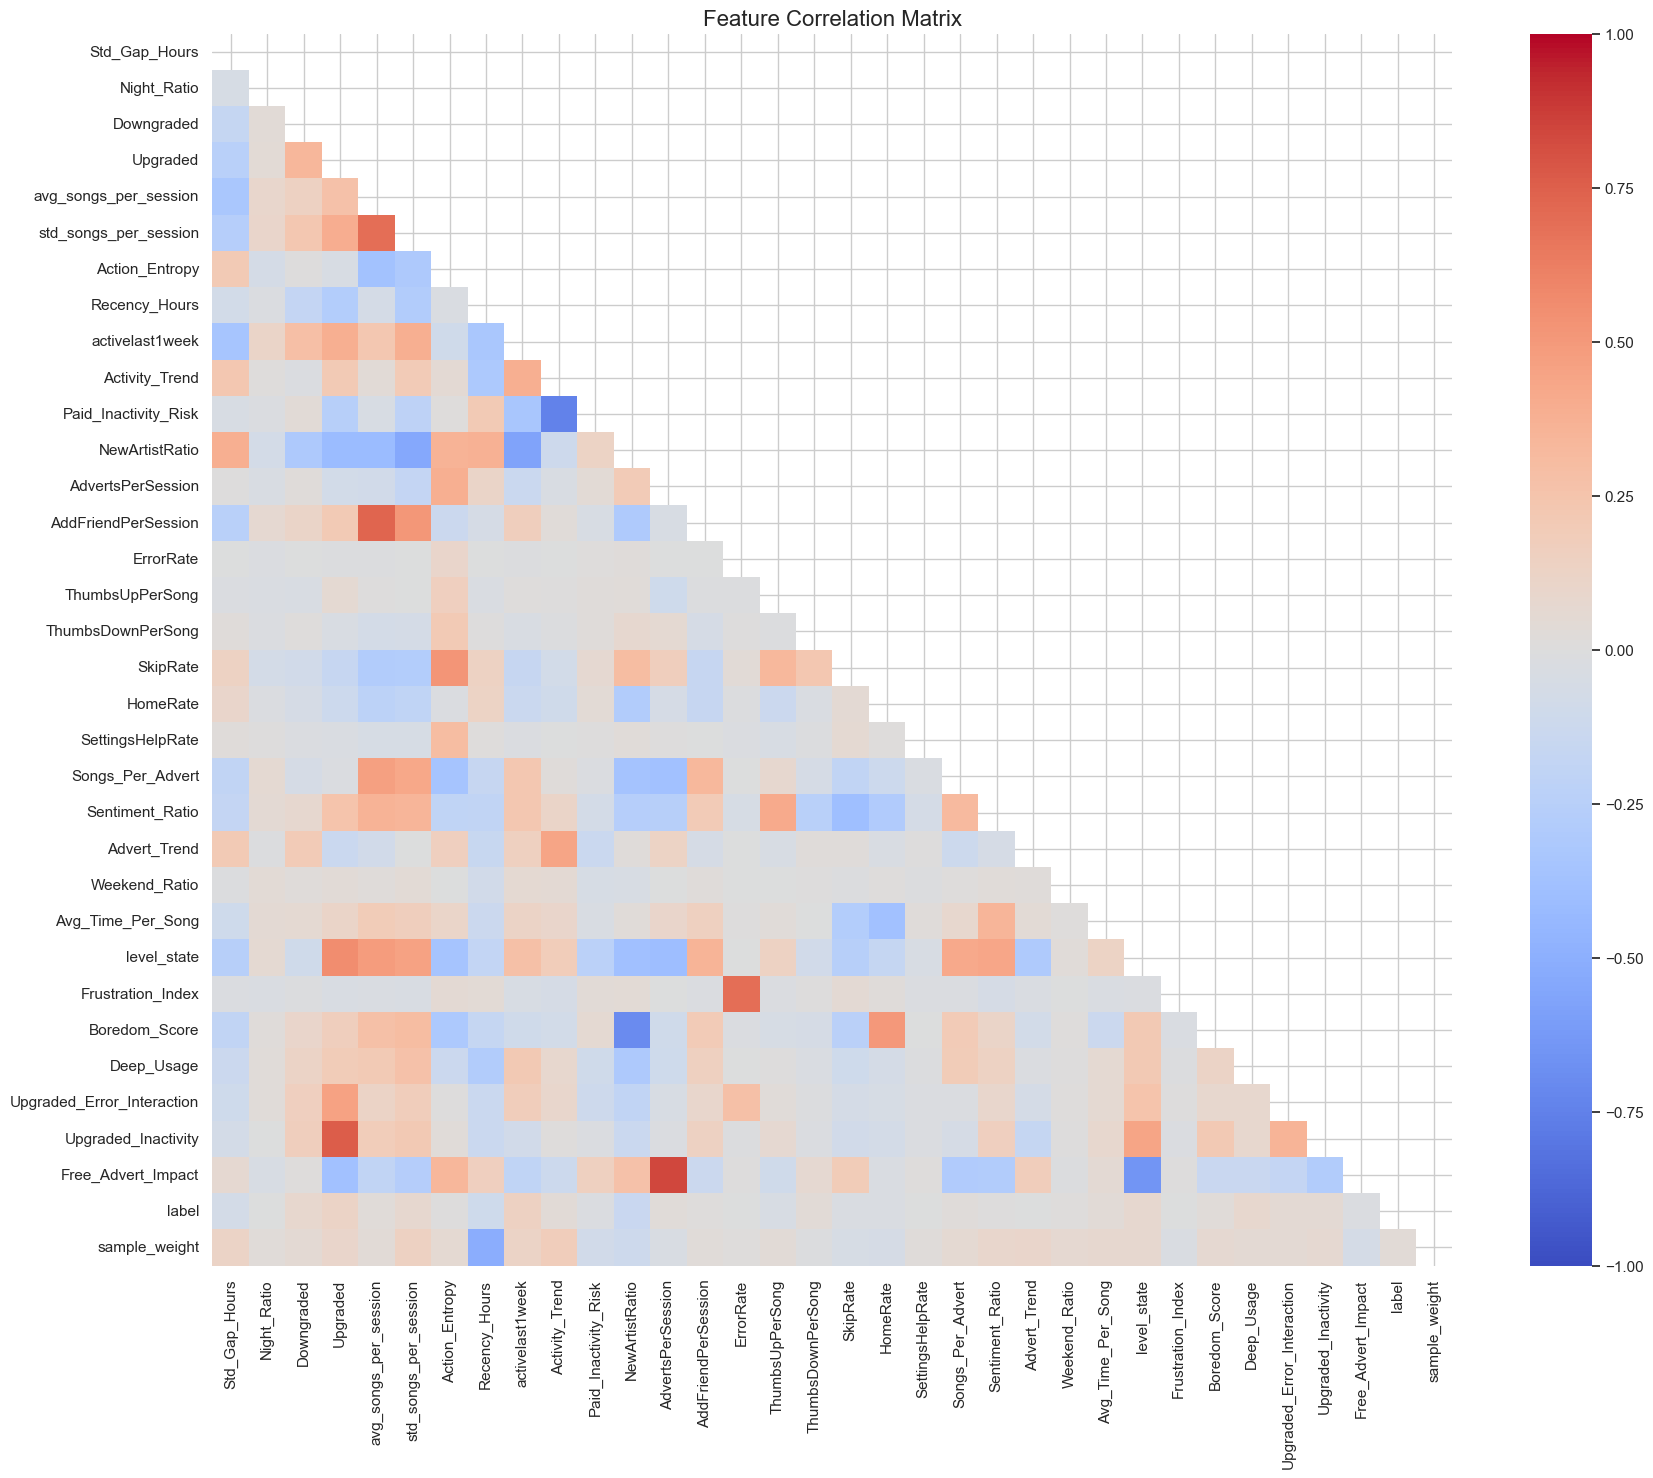


 High Multicollinearity Check (Threshold > 0.8) ---
Found 1 pairs of highly correlated features:
------------------------------------------------------------
Feature A                      | Feature B                      | Corr
------------------------------------------------------------
AdvertsPerSession              | Free_Advert_Impact             | 0.8377
------------------------------------------------------------


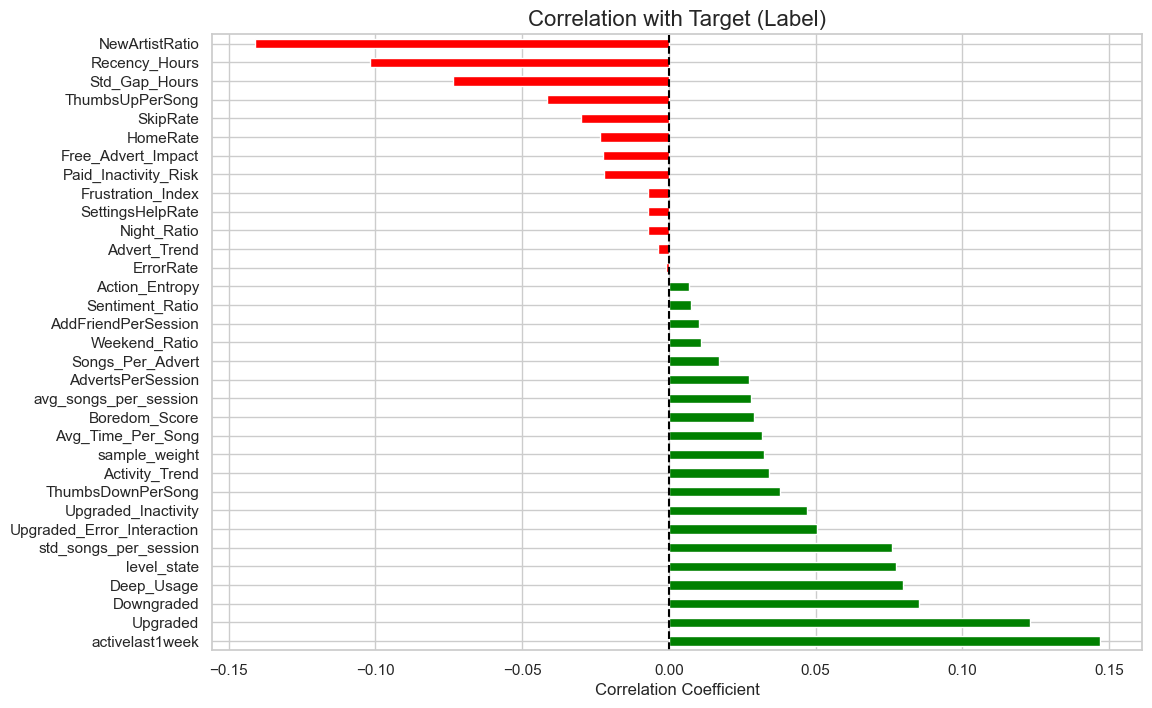


 Top 5 Positive Correlations (Promotes Churn):
activelast1week    0.146927
Upgraded           0.122898
Downgraded         0.085127
Deep_Usage         0.079876
level_state        0.077246
Name: label, dtype: float64

 Top 5 Negative Correlations (Prevents Churn):
SkipRate          -0.029912
ThumbsUpPerSong   -0.041566
Std_Gap_Hours     -0.073455
Recency_Hours     -0.101698
NewArtistRatio    -0.141084
Name: label, dtype: float64
Adversarial Validation AUC: 0.7338

Top 10 Features causing Distribution Drift:
NewArtistRatio                0.149761
Boredom_Score                 0.149463
Advert_Trend                  0.142116
Activity_Trend                0.066318
Paid_Inactivity_Risk          0.058295
Weekend_Ratio                 0.051819
Std_Gap_Hours                 0.051787
Recency_Hours                 0.038995
Upgraded_Error_Interaction    0.035710
Frustration_Index             0.031613
dtype: float64


In [15]:
plot_correlation_analysis(train_df_clean, threshold=0.8)
drift_features = adversarial_validation(train_df_clean, test_df_clean)

In [16]:
train_df_clean.reset_index(drop=True, inplace=True)
test_df_clean.reset_index(drop=True, inplace=True)

Finalizing the feature list. We obviously drop ID and Label. We also drop sample_weight from X; it goes into .fit() separately to handle the Zombies.

In [17]:

feature_cols = [c for c in train_df_clean.columns if c not in ['userId', 'label', 'sample_weight']]

X_train = train_df_clean[feature_cols]
y_train = train_df_clean['label']
w_train = train_df_clean['sample_weight']

X_test = test_df_clean[feature_cols]

Use the final selected features for parameter search and training, here I only used a single XGBoost model

In [18]:
def objective(trial):
    
    # 1. Dynamic Class Balancing. Calculating the scale_pos_weight based on the actual imbalance in y_train. We tune a 'multiplier' to decide how aggressively we punish missing a churner.
    base_ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
    weight_multiplier = trial.suggest_float('pos_weight_multiplier', 0.1, 1.2)
    calculated_weight = base_ratio * weight_multiplier
    
    # 2. Search Space
    param = {
        'n_estimators': 3000, # Set high, let early_stopping handle the cutoff
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 5), # Keep trees shallow to avoid overfitting
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'gamma': trial.suggest_float('gamma', 0.0, 0.5),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'scale_pos_weight': calculated_weight,
        'eval_metric': ['auc', 'aucpr'],
        'random_state': 42,
        'n_jobs': -1,
        'early_stopping_rounds': 100,
        'verbosity': 0
    }
    
    # 3. Manual CV Loop. We need a manual loop to handle sample_weights correctly (Train vs Valid)
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    cv_scores = []
    
    for i, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        w_tr = w_train.iloc[train_idx]
        
        model = XGBClassifier(**param)
        
        model.fit(
            X_tr, y_tr,
            sample_weight=w_tr,        # Train with weights (handle zombies)
            eval_set=[(X_val, y_val)], # Validate on raw data (ground truth check)
            verbose=False
        )
        
        # Predict
        preds = model.predict_proba(X_val)[:, 1]
        score = roc_auc_score(y_val, preds)
        cv_scores.append(score)
        
        # Manual Pruning Hack. The standard PruningCallback is messy with sklearn API.
        # Simple logic: If Fold 0 is trash (< 0.65 AUC), the params are bad.
        if i == 0 and score < 0.65:
            raise optuna.exceptions.TrialPruned()
    
    return np.mean(cv_scores)

# Execution
print("🔥 Starting Optuna Search (Robust Weighted + Optimized Space)...")
# Using MedianPruner to automatically kill the bottom 50% of trials to save time
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
study.optimize(objective, n_trials=50) 

print("\nBest Params Found!")
print(f"Best CV AUC: {study.best_value:.5f}")
print("Best Params:", study.best_params)

[I 2025-12-15 23:15:29,584] A new study created in memory with name: no-name-2683a490-ef48-419c-85ce-0c807f5060fa


🔥 Starting Optuna Search (Robust Weighted + Optimized Space)...


[I 2025-12-15 23:15:36,691] Trial 0 finished with value: 0.7508159249962222 and parameters: {'pos_weight_multiplier': 0.7962465159618122, 'learning_rate': 0.06919845545076041, 'max_depth': 4, 'min_child_weight': 6, 'gamma': 0.44260794002856507, 'subsample': 0.445793281225345, 'colsample_bytree': 0.7941102344736021, 'reg_alpha': 0.000701097986621198, 'reg_lambda': 0.492897792470902}. Best is trial 0 with value: 0.7508159249962222.
[I 2025-12-15 23:15:41,370] Trial 1 finished with value: 0.752717759376916 and parameters: {'pos_weight_multiplier': 0.3688860644366948, 'learning_rate': 0.05148007312585879, 'max_depth': 4, 'min_child_weight': 6, 'gamma': 0.16318427100127514, 'subsample': 0.6280069055143183, 'colsample_bytree': 0.9104520885630705, 'reg_alpha': 2.6329576006366392e-06, 'reg_lambda': 0.035467775198033416}. Best is trial 1 with value: 0.752717759376916.
[I 2025-12-15 23:15:48,835] Trial 2 finished with value: 0.7484310934192909 and parameters: {'pos_weight_multiplier': 0.67983720


Best Params Found!
Best CV AUC: 0.75855
Best Params: {'pos_weight_multiplier': 0.31638420893366426, 'learning_rate': 0.022336335992814604, 'max_depth': 3, 'min_child_weight': 3, 'gamma': 0.22432185153221168, 'subsample': 0.596076321668237, 'colsample_bytree': 0.9170352014676639, 'reg_alpha': 4.047634187467983e-07, 'reg_lambda': 2.932900897789925e-05}


### Why use Rank instead of a fixed Threshold (0.5)?

1. Imbalanced Data: The model might output very low probs (e.g., max 0.2) even for churners. A fixed 0.5 threshold would predict 0 churners.

2. Business Logic: We usually have a target. "Give me the top 5% riskiest users to address." This function forces the submission to match a specific churn rate (top_k_percent).

In [19]:
# Create a function to generate 'submit file'

def create_submission_by_rank(df, top_k_percent, filename):
    # Step A: Calculate Dynamic Threshold
    n_total = len(df)
    n_churn = int(n_total * top_k_percent)

    # Sort by probability (High risk on top)
    df_sorted = df.sort_values(by='probability', ascending=False)

    # Find the exact probability score at the N-th person
    cut_off_prob = df_sorted.iloc[n_churn]['probability']

    # Step B: Generate Binary 0/1 (Temp). Anyone above this dynamic line is marked as Churn (1)
    df['target_temp'] = (df['probability'] >= cut_off_prob).astype(int)

    # Step C: Load Template & Align. We must use the sample_submission file to ensure we have the exact right IDs and row order required by the evaluation system.
    try:
        template = pd.read_csv('example_submission.csv')
    except FileNotFoundError:
        try:
            template = pd.read_csv('sample_submission.csv')
        except:
            print("Template file not found. Please ensure example_submission.csv exists.")
            return

    # Force ID types to match (frequent bug: one is int, one is str -> merge fails)
    try:
        df['id'] = df['id'].astype(template['id'].dtype)
    except:
        template['id'] = template['id'].astype(str)
        df['id'] = df['id'].astype(str)

    # Determine key (Is it 'id' or 'userId'?)
    merge_col = 'id' if 'id' in template.columns else 'userId'
    if merge_col not in df.columns:
        df = df.rename(columns={'id': merge_col})

    # Merge
    final_sub = template[[merge_col]].merge(df[[merge_col, 'target_temp']], on=merge_col, how='left')

    # Step D: Final Cleanup
    # Fill missing values (if any) and ensure integer format
    final_sub['target'] = final_sub['target_temp'].fillna(0).astype(int)

    # Keep only the columns required by Kaggle/Evaluator
    final_output = final_sub[[merge_col, 'target']]

    # Save
    final_output.to_csv(filename, index=False)
    print(f"File {filename} generated successfully.")
    print(f"   - Predicted Churners: {final_sub['target'].sum()} users (Top {top_k_percent * 100}%)")
    print(f"   - Column Check: {final_output.columns.tolist()}")

### Why 10 seeds? 

One model is unstable. By averaging 10 runs with different random states, we reduce variance and prevent the model from memorizing specific "lucky" splits.

In [20]:
# Merge the results of ten seeds to ensure the stability of the outcome

# 1. Parameter Locking
final_params = study.best_params.copy()
final_params.update({
    'n_estimators': 5000,          # Give it a high cap, let early_stopping cut it
    'eval_metric': ['auc', 'aucpr'],
    'n_jobs': -1,
    'early_stopping_rounds': 100,  # Patience level
    'verbosity': 0,
    'objective': 'binary:logistic',
    'tree_method': 'hist'          # Faster training
})

print("\nHyperparameters Locked.")

# 10-Seed Blending (Strict Weighted Mode)
seeds = [42, 2023, 888, 1234, 9999, 1001, 777, 666, 520, 123]

# Initialize zero arrays for accumulation
final_test_preds = np.zeros(len(X_test))
xgb_oof_preds = np.zeros(len(X_train))
seed_scores = []

print(f"\n Starting 10-Seed Blend (Weighted)...")

for seed in seeds:
    # Set random state for this run
    current_params = final_params.copy()
    current_params['random_state'] = seed
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    
    # Containers for this specific seed
    seed_oof = np.zeros(len(X_train))
    seed_test_accum = np.zeros(len(X_test))
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
        # A. Split
        X_tr, y_tr = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_val, y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]
        w_tr = w_train.iloc[train_idx] # Weights for training only
        
        # B. Init
        model = XGBClassifier(**current_params)
        
        # C. Fit
        model.fit(
            X_tr, y_tr,
            sample_weight=w_tr,        # Train: Use weights (handle zombies)
            eval_set=[(X_val, y_val)], # Valid: No weights (Real world check)
            verbose=False
        )
        
        # D. Predict (Compatibility Fix), XGBoost 2.0+ prefers explicit iteration ranges for best models.
        # This prevents using the final (overfitted) tree instead of the best one.
        try:
            best_iter = model.best_iteration + 1
            val_pred = model.predict_proba(X_val, iteration_range=(0, best_iter))[:, 1]
            test_pred = model.predict_proba(X_test, iteration_range=(0, best_iter))[:, 1]
        except AttributeError:
            # Fallback for older versions or if early stopping didn't trigger
            val_pred = model.predict_proba(X_val)[:, 1]
            test_pred = model.predict_proba(X_test)[:, 1]

        # Store results
        seed_oof[val_idx] = val_pred
        seed_test_accum += test_pred / 5  # Average over folds
        
    # Log score for this seed
    score = roc_auc_score(y_train, seed_oof)
    seed_scores.append(score)
    print(f"   -> Seed {seed} CV AUC: {score:.5f}")
    
    # Add to global blend
    xgb_oof_preds += seed_oof / len(seeds)
    final_test_preds += seed_test_accum / len(seeds)

# 3. Final Evaluation & Export
final_cv_score = roc_auc_score(y_train, xgb_oof_preds)
print("\n" + "="*40)
print(f"Final Ensemble CV AUC: {final_cv_score:.5f}")
print(f"Average Single Model AUC: {np.mean(seed_scores):.5f}")
print("="*40)

# Generate Submission. Using the test dataframe to ensure we match UserIDs correctly
rank_df_final = pd.DataFrame({
    'id': test_df_clean['userId'], 
    'probability': final_test_preds
})

# Using the rank-based function to create binary labels. Setting top_k to 50% for now (neutral). If we know the business churn rate is ~5%, we should set this to ~0.07 later.
create_submission_by_rank(
    rank_df_final, 
    top_k_percent=0.50,   
    filename="submission_Weighted_Seeds.csv"
)


Hyperparameters Locked.

 Starting 10-Seed Blend (Weighted)...
   -> Seed 42 CV AUC: 0.75604
   -> Seed 2023 CV AUC: 0.75576
   -> Seed 888 CV AUC: 0.75242
   -> Seed 1234 CV AUC: 0.75265
   -> Seed 9999 CV AUC: 0.75661
   -> Seed 1001 CV AUC: 0.75402
   -> Seed 777 CV AUC: 0.75566
   -> Seed 666 CV AUC: 0.75717
   -> Seed 520 CV AUC: 0.75846
   -> Seed 123 CV AUC: 0.75076

Final Ensemble CV AUC: 0.76075
Average Single Model AUC: 0.75495
File submission_Weighted_Seeds.csv generated successfully.
   - Predicted Churners: 1453 users (Top 50.0%)
   - Column Check: ['id', 'target']


#### Diagnostic : Probability Histogram. 

Is the model confident or confused?

We want a U-shape (peaks at 0 and 1). If it looks like a bell curve around 0.1, the model is conservative.

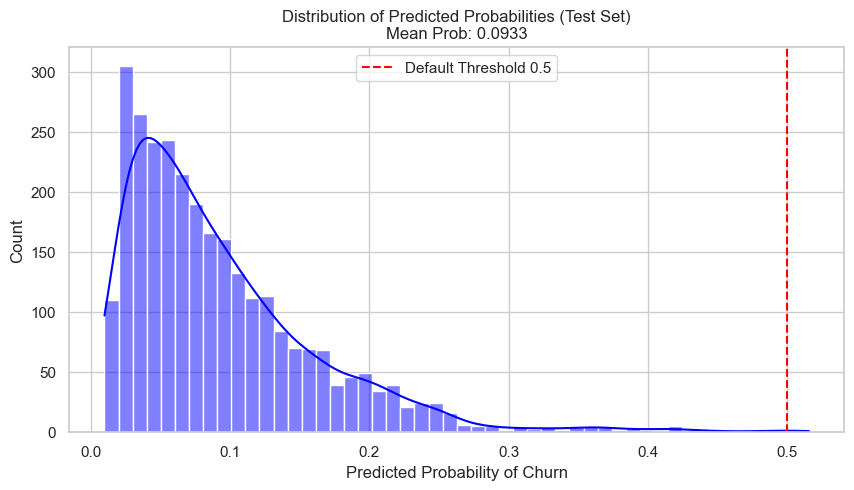


Strategy Backtesting (Simulation on Train) ---
Current Strategy (Top 50%): Accuracy=0.5420, Precision=0.1069
Adjusted Strategy (Top 10%): Accuracy=0.8782, Precision=0.2153

 Top 20 Features driving the Model
                       Feature      Gain
3                     Upgraded  0.116941
8              activelast1week  0.070797
11              NewArtistRatio  0.070732
15             ThumbsUpPerSong  0.048493
29  Upgraded_Error_Interaction  0.040485
16           ThumbsDownPerSong  0.037925
30         Upgraded_Inactivity  0.034772
7                Recency_Hours  0.033736
20            Songs_Per_Advert  0.030968
6               Action_Entropy  0.030263
0                Std_Gap_Hours  0.028264
12           AdvertsPerSession  0.028253
5        std_songs_per_session  0.027940
25                 level_state  0.027372
4        avg_songs_per_session  0.027097
13         AddFriendPerSession  0.024892
28                  Deep_Usage  0.024258
31          Free_Advert_Impact  0.023802
1           

In [21]:
plt.figure(figsize=(10, 5))
sns.histplot(final_test_preds, bins=50, kde=True, color='blue')
plt.title(f'Distribution of Predicted Probabilities (Test Set)\nMean Prob: {np.mean(final_test_preds):.4f}')
plt.xlabel('Predicted Probability of Churn')
plt.ylabel('Count')
plt.axvline(x=0.5, color='red', linestyle='--', label='Default Threshold 0.5')
plt.legend()
plt.show()

# Diagnostic 2: Strategy Backtesting (Simulation on Train)

# We use the Out-of-Fold (OOF) predictions from the training set because we know the True Label (y_train), so we can verify if the strategy works.

print("\nStrategy Backtesting (Simulation on Train) ---")

# Scenario A: Your current strategy (Top 50%)
# This forces the model to flag half the population. Usually bad for precision.
cut_off_50 = np.percentile(xgb_oof_preds, 100 - 50) # Find the score at the 50% mark
y_pred_50 = (xgb_oof_preds >= cut_off_50).astype(int)

acc_50 = accuracy_score(y_train, y_pred_50)
prec_50 = precision_score(y_train, y_pred_50)
print(f"Current Strategy (Top 50%): Accuracy={acc_50:.4f}, Precision={prec_50:.4f}")

# Scenario B: Realistic Strategy (Top 10%)
# This targets the riskiest users. Precision should skyrocket here.
cut_off_10 = np.percentile(xgb_oof_preds, 100 - 10) # Find the score at the 10% mark
y_pred_10 = (xgb_oof_preds >= cut_off_10).astype(int)

acc_10 = accuracy_score(y_train, y_pred_10)
prec_10 = precision_score(y_train, y_pred_10)
print(f"Adjusted Strategy (Top 10%): Accuracy={acc_10:.4f}, Precision={prec_10:.4f}")


# Diagnostic 3: Feature Importance (Did the model learn logic or noise?)
# Checking the last model from the loop to see what it prioritized.
print("\n Top 20 Features driving the Model")
if hasattr(model, 'feature_importances_'):
    imp_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Gain': model.feature_importances_
    }).sort_values(by='Gain', ascending=False).head(20)
    print(imp_df)
else:
    print("Cannot extract feature importance (Check model object).")

Trees (XGB) are great, but sometimes a simple linear line finds patterns trees miss. Converting to Numpy arrays to avoid index alignment headaches during CV.

In [22]:

X_np = X_train.values
y_np = y_train.values
w_np = w_train.values

def objective_lr(trial):
    # 1. Define Search Space with C: Inverse of regularization strength.
    c_value = trial.suggest_float('C', 0.001, 10.0, log=True)
    
    # Class Weight: Handling the imbalance. Since churn is rare, we search for a multiplier to make the Churn class "heavier".
    weight_multiplier = trial.suggest_float('class_weight_multiplier', 1.0, 10.0)
    class_weight = {0: 1.0, 1: weight_multiplier}
    
    # 2. Build Pipeline
    # Logistic Regression is picky (unlike Trees): It dies on NaNs -> Need SimpleImputer & It fails if features have different scales -> Need StandardScaler
    model = make_pipeline(
        SimpleImputer(strategy='mean'),
        StandardScaler(),
        LogisticRegression(
            C=c_value,
            class_weight=class_weight,
            solver='lbfgs',
            max_iter=1000, # Tweaked this up so it doesn't complain about "ConvergenceWarning"
            random_state=42
        )
    )
    
    # 3. Cross Validation
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []
    
    for train_idx, val_idx in kf.split(X_np, y_np):
        X_tr, y_tr = X_np[train_idx], y_np[train_idx]
        X_val, y_val = X_np[val_idx], y_np[val_idx]
      
        model.fit(X_tr, y_tr)
        
        preds = model.predict_proba(X_val)[:, 1]
        auc_scores.append(roc_auc_score(y_val, preds))
    
    return np.mean(auc_scores)

print("Starting Logistic Regression Search...")
# LR is fast, so 20 trials is usually enough to find the sweet spot
study_lr = optuna.create_study(direction='maximize')
study_lr.optimize(objective_lr, n_trials=20) 

print(f"Best LR Params: {study_lr.best_params}")
best_lr_params = study_lr.best_params

[I 2025-12-15 23:20:47,914] A new study created in memory with name: no-name-e94de0de-f3f6-43d0-9332-3b05a27c0f5e


Starting Logistic Regression Search...


[I 2025-12-15 23:20:48,128] Trial 0 finished with value: 0.7472822651604918 and parameters: {'C': 0.06591198207023788, 'class_weight_multiplier': 1.1358286722759807}. Best is trial 0 with value: 0.7472822651604918.
[I 2025-12-15 23:20:48,251] Trial 1 finished with value: 0.7406334648373963 and parameters: {'C': 0.0014556769939572589, 'class_weight_multiplier': 3.9779541301279395}. Best is trial 0 with value: 0.7472822651604918.
[I 2025-12-15 23:20:48,472] Trial 2 finished with value: 0.7480442216388288 and parameters: {'C': 0.4309765145593518, 'class_weight_multiplier': 4.862082735829966}. Best is trial 2 with value: 0.7480442216388288.
[I 2025-12-15 23:20:48,640] Trial 3 finished with value: 0.74809726309424 and parameters: {'C': 0.02161238854532323, 'class_weight_multiplier': 9.873149134820949}. Best is trial 3 with value: 0.74809726309424.
[I 2025-12-15 23:20:48,922] Trial 4 finished with value: 0.7481364482741866 and parameters: {'C': 0.047770856698109695, 'class_weight_multiplier'

Best LR Params: {'C': 0.047770856698109695, 'class_weight_multiplier': 6.373957044439809}


### LOGISTIC REGRESSION ENSEMBLE (10 Seeds)

Even though LR is stable, blending seeds helps smooth out any quirks from the Cross-Validation splits.

In [23]:
seeds = [42, 2023, 888, 1234, 9999, 1001, 777, 666, 520, 123]

# Parse best params from Optuna
best_C = best_lr_params['C']
best_weight_ratio = best_lr_params['class_weight_multiplier']
final_class_weight = {0: 1.0, 1: best_weight_ratio}

# Init containers
lr_test_preds = np.zeros(len(X_test))
lr_oof_preds = np.zeros(len(X_train))
lr_seed_scores = []

# Convert test set to numpy once to save time inside the loop
X_test_np = X_test.values

print(f"\n Starting Logistic Regression 10-Seed Blend...")

for seed in seeds:
    # Build pipeline for this seed
    model_pipeline = make_pipeline(
        SimpleImputer(strategy='mean'),
        StandardScaler(),
        LogisticRegression(
            C=best_C,
            class_weight=final_class_weight,
            solver='lbfgs',
            max_iter=2000,
            random_state=seed # Varying the seed
        )
    )
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    
    seed_oof = np.zeros(len(X_train))
    seed_test_accum = np.zeros(len(X_test))
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_np, y_np)):
        X_tr, y_tr = X_np[train_idx], y_np[train_idx]
        X_val, y_val = X_np[val_idx], y_np[val_idx]
        
        model_pipeline.fit(X_tr, y_tr)
        
        val_pred = model_pipeline.predict_proba(X_val)[:, 1]
        test_pred = model_pipeline.predict_proba(X_test_np)[:, 1]
        
        seed_oof[val_idx] = val_pred
        seed_test_accum += test_pred / 5
        
    score = roc_auc_score(y_np, seed_oof)
    lr_seed_scores.append(score)
    print(f"   -> LR Seed {seed} CV AUC: {score:.5f}")
    
    lr_oof_preds += seed_oof / len(seeds)
    lr_test_preds += seed_test_accum / len(seeds)

print(f"LR Final Ensemble CV AUC: {roc_auc_score(y_train, lr_oof_preds):.5f}")


 Starting Logistic Regression 10-Seed Blend...
   -> LR Seed 42 CV AUC: 0.74787
   -> LR Seed 2023 CV AUC: 0.74581
   -> LR Seed 888 CV AUC: 0.74701
   -> LR Seed 1234 CV AUC: 0.74741
   -> LR Seed 9999 CV AUC: 0.74539
   -> LR Seed 1001 CV AUC: 0.74409
   -> LR Seed 777 CV AUC: 0.74566
   -> LR Seed 666 CV AUC: 0.74563
   -> LR Seed 520 CV AUC: 0.74681
   -> LR Seed 123 CV AUC: 0.74813
LR Final Ensemble CV AUC: 0.74721


We are mixing a Tree model (XGB) with a Linear model (LR).

In [24]:
# Since their raw probability distributions look completely different (XGB is extreme, LR is clustered in the middle), we cannot average them directly.
# So we use Rank Blending: we average their rankings of users.

print("\n Executing Final Heterogeneous Ensemble (XGB + LR)...")

# 1. Set Weights: Trust the Tree model for 95% of the signal. The LR is just here to provide a linear "safety check" for edge cases.
w_xgb = 0.95
w_lr  = 0.05

print(f"Weight Ratio: XGBoost = {w_xgb}, Logistic Regression = {w_lr}")

# 2. Blending: Checking if we actually have the XGB predictions in memory
if 'final_test_preds' not in locals():
    print("Error: XGBoost predictions (final_test_preds) not found.")
else:
    # Rank Blending Logic: Convert probs to ranks (1 to N), normalize to (0~1), then weighted average.
    final_blend_rank = w_xgb * (rankdata(final_test_preds) / len(final_test_preds)) + \
                       w_lr * (rankdata(lr_test_preds) / len(lr_test_preds))

    # 3. Generate Submission
    rank_df_final = pd.DataFrame({
        'id': test_df_clean['userId'], 
        'probability': final_blend_rank 
    })

    print(f"\nGenerating final submission. Strictly enforcing Top 50% cutoff...")

    create_submission_by_rank(
        rank_df_final, 
        top_k_percent=0.50,
        filename="submission_XGB_LR_Ensemble_50pct.csv"
    )


 Executing Final Heterogeneous Ensemble (XGB + LR)...
Weight Ratio: XGBoost = 0.95, Logistic Regression = 0.05

Generating final submission. Strictly enforcing Top 50% cutoff...
File submission_XGB_LR_Ensemble_50pct.csv generated successfully.
   - Predicted Churners: 1453 users (Top 50.0%)
   - Column Check: ['id', 'target']
